In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="P6vGDWzSCEIJ02uKfWRE")

# 1) Specify your workspace (the part before the slash in the project URL)
ws = rf.workspace("capstone-v5")

# 2) Then load the project (the part after the slash)
project = ws.project("manga-panels-jxuz5-lijsg-1gosm-ccatd")

# 3) Pick the version (usually v1) and download in YOLOv5 format
version = project.version(1)
dataset = version.download("yolov5")

print("Saved to:", dataset.location)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Manga-Panels-1 in yolov5pytorch:: 100%|██████████| 6059/6059 [00:00<00:00, 12324.72it/s]


Saved to: /home/chanakya/chanakya/UNI/translation_tool/Manga-Panels-1


In [3]:
IMAGE_PATH = "data/images/train/0001.jpg" 
ROBOFLOW_API_KEY = "P6vGDWzSCEIJ02uKfWRE"   

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html


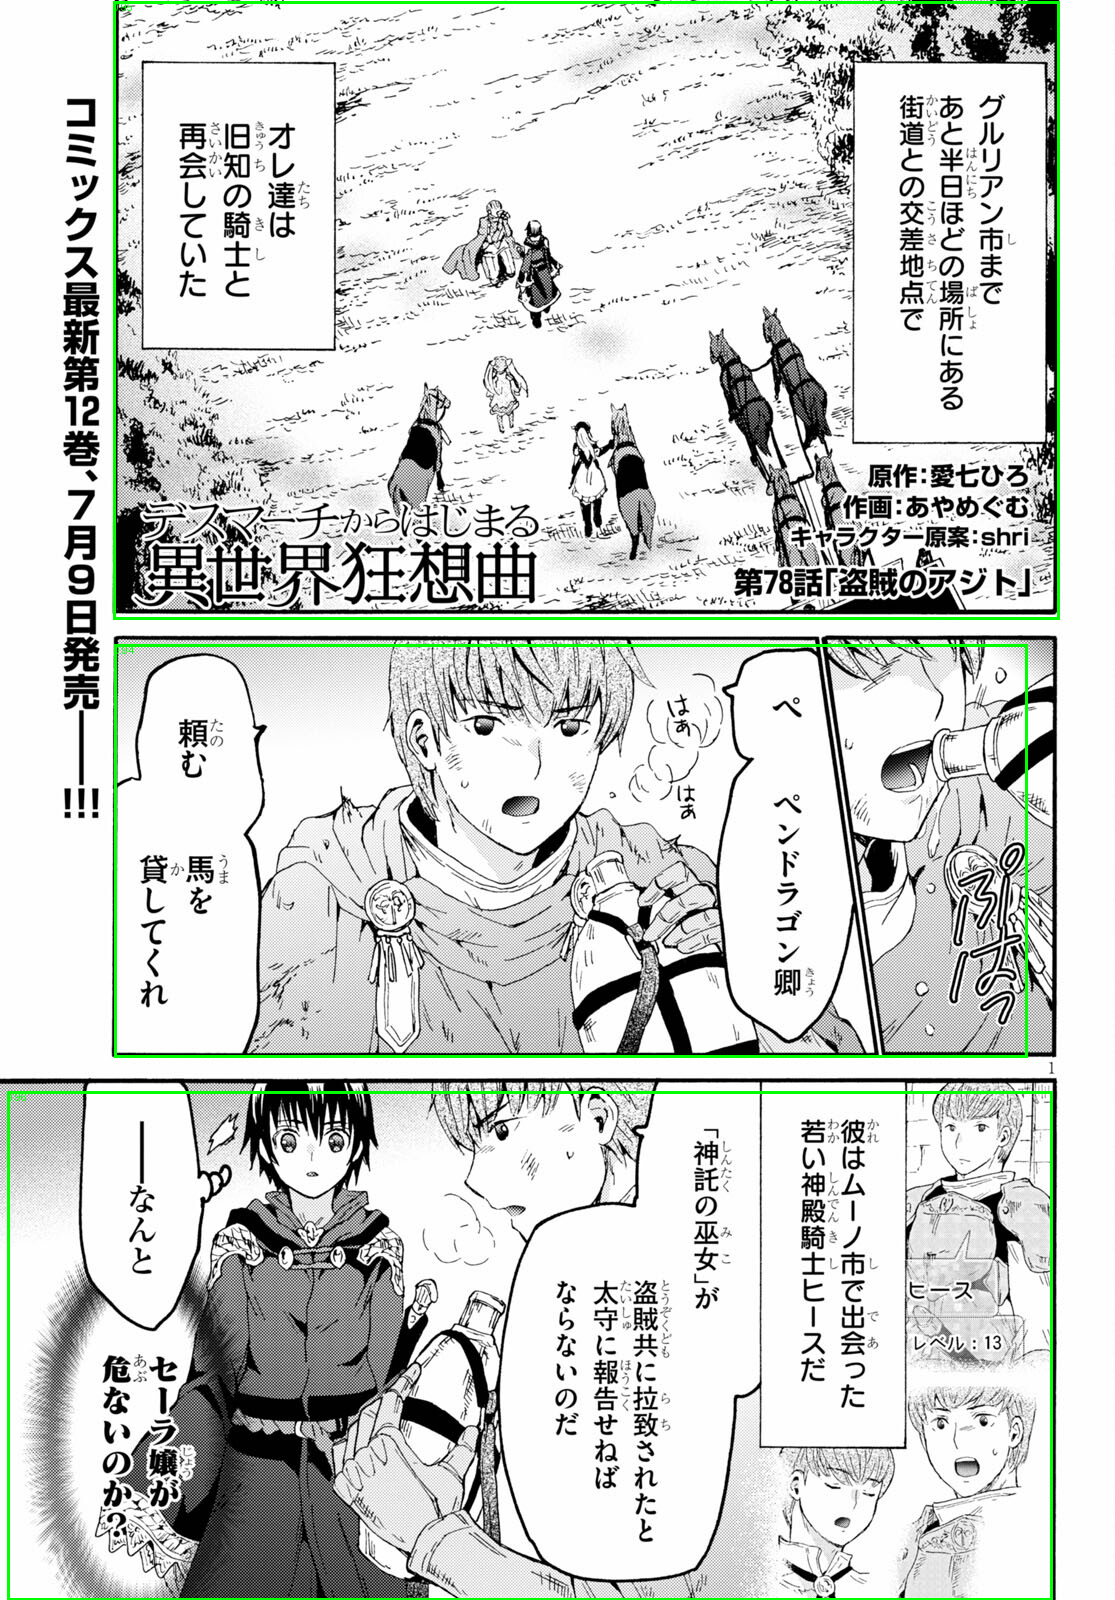

✅  Detected 3 panels


In [4]:
PROJECT_SLUG     = "manga-panels-jxuz5-lijsg-1gosm-ccatd"  # project-slug (model ID for detect.roboflow.com)
VERSION          = "1"                      # model version (use 1 if unsure)
CONFIDENCE       = 0.4                      # 0-1
OVERLAP          = 30                       # NMS overlap (pixels)

# -------------------------------------------------------------------------
import io, sys, subprocess, pkg_resources, requests
from PIL import Image, ImageDraw
from IPython.display import display

# install tiny deps if missing
for p in ("requests", "Pillow"):
    try:
        pkg_resources.get_distribution(p)
    except pkg_resources.DistributionNotFound:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

def detect_panels(img_bytes):
    if not ROBOFLOW_API_KEY or ROBOFLOW_API_KEY.startswith("YOUR"):
        raise ValueError("Set your ROBOFLOW_API_KEY first!")
    url = f"https://detect.roboflow.com/{PROJECT_SLUG}/{VERSION}"
    r = requests.post(
        url,
        params={
            "api_key": ROBOFLOW_API_KEY,
            "confidence": int(CONFIDENCE * 100),
            "overlap": OVERLAP,
        },
        files={"file": img_bytes},
        timeout=60,
    )
    r.raise_for_status()
    return r.json()

# read image -> bytes
with open(IMAGE_PATH, "rb") as f:
    img_bytes = f.read()

response = detect_panels(img_bytes)

# draw predictions
img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
draw = ImageDraw.Draw(img)
for p in response["predictions"]:
    x, y, w, h = p["x"], p["y"], p["width"], p["height"]
    draw.rectangle(
        [x - w / 2, y - h / 2, x + w / 2, y + h / 2],
        outline="lime",
        width=3,
    )
    draw.text((x - w / 2, y - h / 2), f'{p["confidence"]:.2f}', fill="lime")

display(img)
print(f"✅  Detected {len(response['predictions'])} panels")

In [5]:
PROJECT_SLUG = "chapterocr/manga-panels"   # new slug
VERSION      = "6"                         # latest
from ultralytics import YOLO
import os

# download once (weights ≈ 10-25 MB)
# Assuming dataset.location is defined from cell 0 and contains the downloaded model weights.
# Common path for weights in Roboflow YOLOv5 export is dataset.location/weights/best.pt
MODEL_PATH = os.path.join(dataset.location, "weights", "best.pt")

model = YOLO(MODEL_PATH)
# Use IMAGE_PATH defined in cell 1 for consistency
results = model(IMAGE_PATH, conf=0.25, iou=0.5)[0]

# Use IMAGE_PATH defined in cell 1
img = Image.open(IMAGE_PATH).convert("RGB"); draw = ImageDraw.Draw(img)
for box in results.boxes.xyxy.cpu().numpy():
    x1, y1, x2, y2 = map(int, box[:4])
    draw.rectangle([x1, y1, x2, y2], outline="lime", width=3)
img


FileNotFoundError: [Errno 2] No such file or directory: '/home/chanakya/chanakya/UNI/translation_tool/Manga-Panels-1/weights/best.pt'

In [6]:
# offline_panel_demo.ipynb -------------------------------------------
%pip install supervision opencv-python
# Ensure 'inference.py' is in the same directory or installed as a package
from inference import get_model
import supervision as sv          # quick drawing helpers
import cv2, os

#  ⬅⬅  put your key in an ENV variable for first download only
# ROBOFLOW_API_KEY is defined in cell 1
os.environ["ROBOFLOW_API_KEY"] = ROBOFLOW_API_KEY

MODEL_ID = "Manga-Panels-1/"       # slug/version you copied
CONF     = 0.25                   # adjust
# IMAGE_PATH is defined in cell 1
IMAGE    = IMAGE_PATH             # test page

# ① first call downloads weights to ~/.cache → later runs work offline
model   = get_model(model_id=MODEL_ID)          # ↓ local path prints
print("model weights:", model.model_path)

# ② run inference
result  = model.infer(IMAGE, confidence=CONF)[0]  # single-image shortcut
detections = sv.Detections.from_inference(result)

# ③ visualise
annot   = sv.BoxAnnotator(color=sv.Color.green(), thickness=2, text_color=sv.Color.white())
frame   = cv2.imread(IMAGE)
if frame is not None:
	frame   = annot.annotate(scene=frame, detections=detections)
	sv.plot_image(frame, (10, 10))                  # inline in Jupyter
	print("panels detected:", len(detections))
else:
	print(f"Error: Could not read image at path {IMAGE}")


Note: you may need to restart the kernel to use updated packages.


[06/02/25 21:21:19] WARNING  Your inference package version 0.49.5 is out of date! Please upgrade to ]8;id=234577;file:///home/chanakya/chanakya/UNI/translation_tool/manga-env/lib/python3.12/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=592210;file:///home/chanakya/chanakya/UNI/translation_tool/manga-env/lib/python3.12/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.50.3 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

E0000 00:00:1748892081.807496   14665 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748892081.816214   14665 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748892081.883217   14665 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748892081.883232   14665 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748892081.883234   14665 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748892081.883235   14665 computation_placer.cc:177] computation placer already registered. Please check linka

RoboflowAPIUnsuccessfulRequestError: Unsuccessful request to Roboflow API with response code: 403

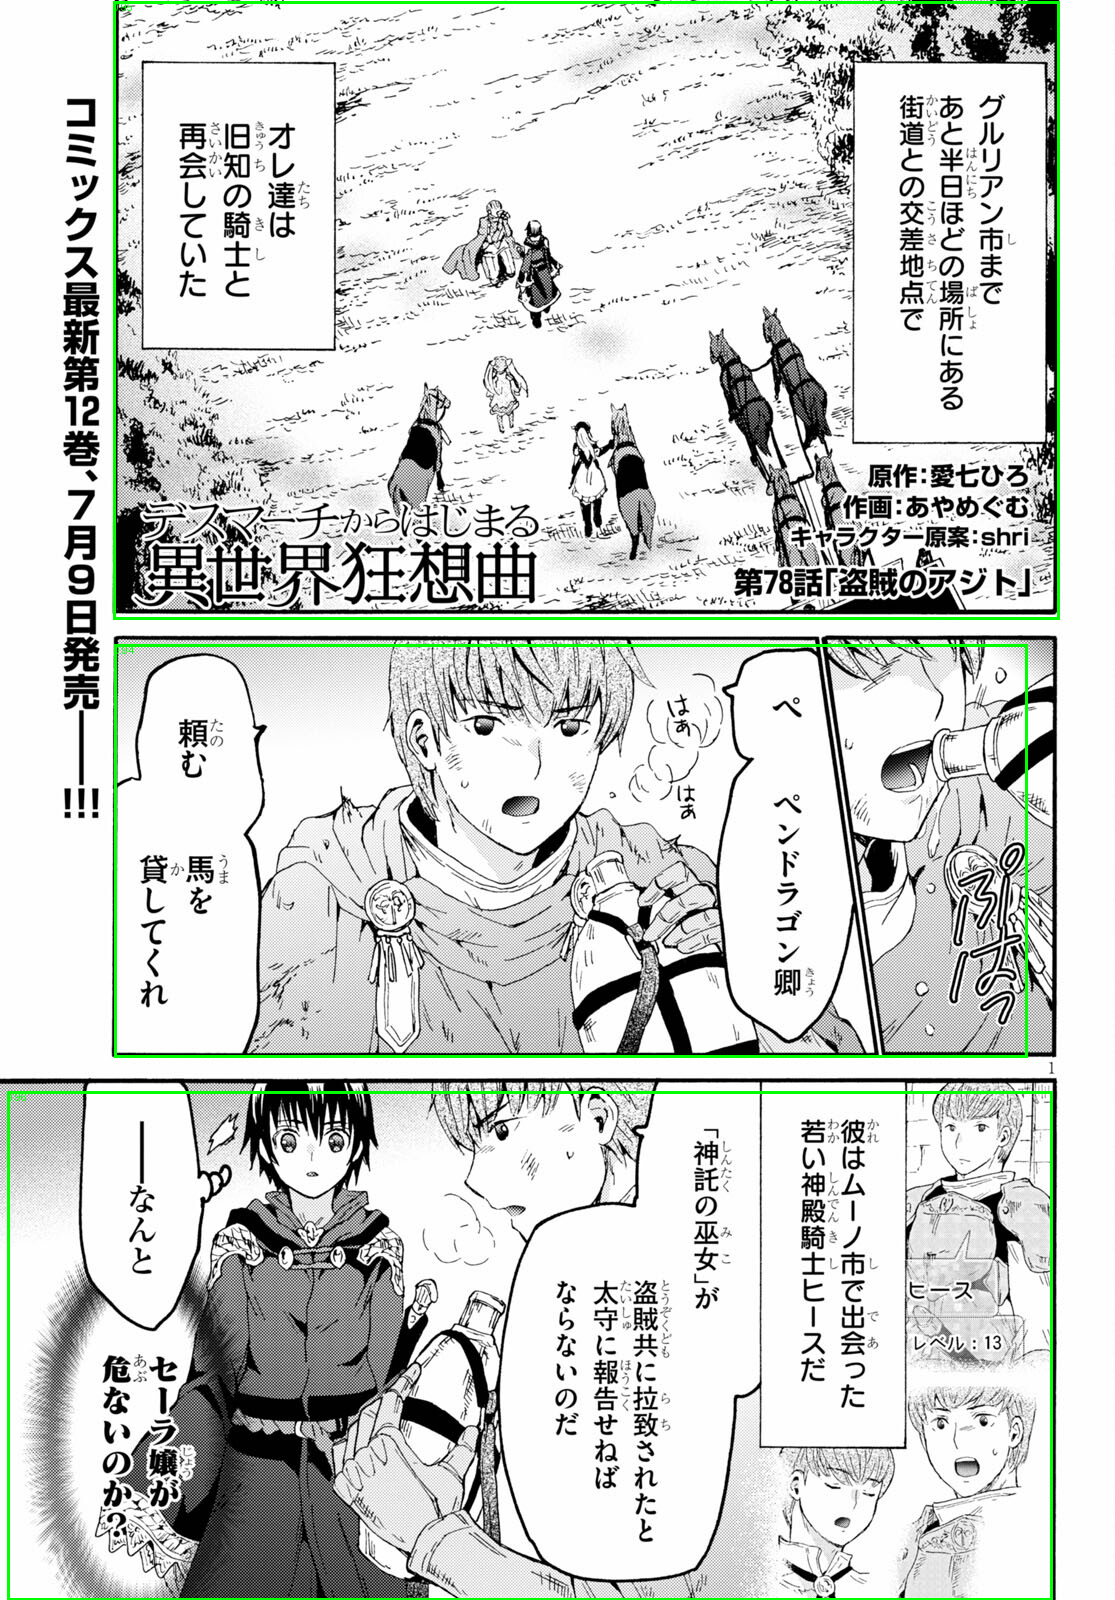

✅  Ensemble best run detected 3 panels (score 2.84)


In [ ]:
# ⬛⬛⬛  Ensemble Panel Detection (select best run)  ⬛⬛⬛

def detect_panels(img_bytes):
    """Single API call to Roboflow."""
    if not ROBOFLOW_API_KEY or ROBOFLOW_API_KEY.startswith("YOUR"):
        raise ValueError("Set your ROBOFLOW_API_KEY first!")
    url = f"https://detect.roboflow.com/{PROJECT_SLUG}/{VERSION}"
    r = requests.post(
        url,
        params={
            "api_key": ROBOFLOW_API_KEY,
            "confidence": int(CONFIDENCE * 100),
            "overlap": OVERLAP,
        },
        files={"file": img_bytes},
        timeout=60,
    )
    r.raise_for_status()
    return r.json()["predictions"]

def detect_best(img_bytes, runs=5):
    """
    Run detect_panels multiple times and pick the run
    with the highest total confidence (sum of confidences).
    Returns (best_predictions, best_score).
    """
    best_preds = []
    best_score = -1.0
    for _ in range(runs):
        preds = detect_panels(img_bytes)
        score = sum(p["confidence"] for p in preds)
        if score > best_score:
            best_score = score
            best_preds = preds
    return best_preds, best_score

# Load image once
with open(IMAGE_PATH, "rb") as f:
    img_bytes = f.read()

# Run ensemble detection
ensemble_preds, best_score = detect_best(img_bytes, runs=5)

# Visualize the best predictions
img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
draw = ImageDraw.Draw(img)
for p in ensemble_preds:
    x, y, w, h = p["x"], p["y"], p["width"], p["height"]
    x1, y1 = x - w/2, y - h/2
    x2, y2 = x + w/2, y + h/2
    draw.rectangle([x1, y1, x2, y2], outline="lime", width=3)
    draw.text((x1, y1), f'{p["confidence"]:.2f}', fill="lime")

display(img)
print(f"✅  Ensemble best run detected {len(ensemble_preds)} panels (score {best_score:.2f})")


In [7]:
from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer,
    VisionEncoderDecoderPipeline,
)
import torch
from huggingface_hub import notebook_login

# 1) Authenticate if needed
notebook_login()

# 2) Select device + dtype
device = 0 if torch.cuda.is_available() else -1
dtype  = torch.bfloat16 if device == 0 else torch.float32

# 3) Load model, extractor, tokenizer (with trust_remote_code)
model = VisionEncoderDecoderModel.from_pretrained(
    "google/gemma-3-4b-it",
    trust_remote_code=True,
    torch_dtype=dtype,
)
feature_extractor = AutoFeatureExtractor.from_pretrained(
    "google/gemma-3-4b-it",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-3-4b-it",
    trust_remote_code=True,
)

# 4) Create the pipeline explicitly
pipe = VisionEncoderDecoderPipeline(
    model=model,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    device=device,      # GPU index or -1 for CPU
)

# 5) Test it on an image
from PIL import Image
img = Image.open("path/to/your/image.jpg")
print(pipe(img))


ImportError: cannot import name 'VisionEncoderDecoderPipeline' from 'transformers' (/home/chanakya/chanakya/UNI/translation_tool/manga-env/lib/python3.12/site-packages/transformers/__init__.py)

In [1]:
%pip install -q torchvision accelerate
from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer,
    
)
import torch
from huggingface_hub import notebook_login

# Log in if needed
notebook_login()

# Choose device/dtype
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.bfloat16 if device=="cuda" else torch.float32

model_id = "google/gemma-3-4b-it"

# Load model, feature extractor, and tokenizer
# This explicit setup is often more robust for models with remote code
model_obj = VisionEncoderDecoderModel.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype=dtype,
)
# The pipeline will handle moving the model to the specified device.

feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    trust_remote_code=True,
)

# Create the VisionEncoderDecoderPipeline
pipe = VisionEncoderDecoderPipeline(
    model=model_obj,
    feature_extractor=feature_extractor,
    tokenizer=tokenizer,
    device=device,  # "cuda" or "cpu"
)

# Quick test
from PIL import Image # Ensure PIL is imported for Image.open
img = Image.open(IMAGE_PATH) # IMAGE_PATH is defined in a previous cell
print(pipe(img))


Note: you may need to restart the kernel to use updated packages.


2025-06-02 21:21:46.542997: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 21:21:46.551095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748892106.560146   19974 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748892106.562819   19974 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748892106.570393   19974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

You are using a model of type gemma3 to instantiate a model of type vision-encoder-decoder. This is not supported for all configurations of models and can yield errors.


ValueError: A configuraton of type gemma3 cannot be instantiated because not both `encoder` and `decoder` sub-configurations are passed, but only {'architectures': ['Gemma3ForConditionalGeneration'], 'boi_token_index': 255999, 'eoi_token_index': 256000, 'eos_token_id': [1, 106], 'image_token_index': 262144, 'initializer_range': 0.02, 'mm_tokens_per_image': 256, 'model_type': 'gemma3', 'text_config': {'hidden_size': 2560, 'intermediate_size': 10240, 'model_type': 'gemma3_text', 'num_hidden_layers': 34, 'rope_scaling': {'factor': 8.0, 'rope_type': 'linear'}, 'sliding_window': 1024}, 'torch_dtype': 'bfloat16', 'transformers_version': '4.50.0.dev0', 'vision_config': {'hidden_size': 1152, 'image_size': 896, 'intermediate_size': 4304, 'model_type': 'siglip_vision_model', 'num_attention_heads': 16, 'num_hidden_layers': 27, 'patch_size': 14, 'vision_use_head': False}, '_commit_hash': '093f9f388b31de276ce2de164bdc2081324b9767', 'attn_implementation': None}

In [2]:
import json
import textwrap
from enum import Enum
from pathlib import Path

import ollama
import pandas as pd
from IPython.display import Image, Markdown, display
from tqdm import tqdm

MODEL = "gemma3:4b"
TEMPERATURE = 1.0
MIN_P = 0.01
REPEAT_PENALTY = 1.0
TOP_K = 64
TOP_P = 0.95




In [3]:
class ResponseFormat(Enum):
        JSON = "json_object"
        TEXT = "text"
        Markdown = "markdown"

def call_model(
    prompt: str,
    response_format: ResponseFormat = ResponseFormat.TEXT,
    system_prompt: str = "",
) -> str:
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": prompt})

    response = ollama.chat(
        model=MODEL,
        messages=messages,
        keep_alive="1h",
        format="" if response_format == ResponseFormat.TEXT else "json",
        options={
            "temperature": TEMPERATURE,
            "min_p": MIN_P,
            "repeat_penalty": REPEAT_PENALTY,
            "top_k": TOP_K,
            "top_p": TOP_P,
        },
    )

    return response.message.content

In [4]:
%%time

LYRICS_PROMPT = """
Compose original hip-hop song lyrics that capture the 90s aesthetic while exploring artificial intelligence and technological future. Requirements:

- Maintain authentic 90s hip-hop linguistic style (slang, flow, cultural references)
- Thematic focus: AI's potential impact on society
- Demonstrate understanding of 90s hip-hop rhythmic and storytelling conventions

Evaluate your response against these criteria:
- Originality of technological narrative
- Authenticity of 90s hip-hop voice
- Rhythmic potential
"""

response = call_model(LYRICS_PROMPT)


CPU times: user 2.65 ms, sys: 91 μs, total: 2.74 ms
Wall time: 13.4 s


In [ ]:
print (f"Response:\n{response}\n")

Response:
Okay, here’s a song attempting to meet those criteria, aiming for a late-90s/early 2000s boom-bap sound with a tech-forward theme. I’ll include notes after the lyrics about how it fulfills the requirements.

---

**(Intro - Sampled synth pad with a dusty drum loop – heavy on the 808 kick)**

"Word up... check the mic... one two... Digital Prophet comin' through..." 

**(Beat drops – heavy, swung 808, crisp snare, subtle hi-hats)**

**(Verse 1)**
Yo, lemme drop some truth, straight from the silicon core
Used to rock the boombox, now I’m battlin' digital lore
Remember dial-up speeds, connectin’ slow and low?
Now the internet’s a flood, information overflow
They buildin’ these machines, smarter than my brain
Algorithms risin’ up, rearrangin’ the game
Used to chase the paper, now it’s data streams
Trackin’ every move, livin’ in digital dreams
Used to be hustlin’ on the block, now it's coded and tight
These robots learnin' faster, day and night
Used to listen to Biggie, Pac, Dre, 

In [5]:
import json
import base64
from enum import Enum
from pathlib import Path

import ollama
from PIL import Image as PILImage

#––– Model / sampling hyperparameters ––––––––––––––––––––––––––––––––––––––
MODEL           = "gemma3:4b"
TEMPERATURE     = 1.0
MIN_P           = 0.01
REPEAT_PENALTY  = 1.0
TOP_K           = 64
TOP_P           = 0.95

class ResponseFormat(Enum):
    JSON = "json_object"
    TEXT = "text"

def call_model(
    prompt: str = "",
    image_path: str | Path = None,
    response_format: ResponseFormat = ResponseFormat.TEXT,
    system_prompt: str = "",
) -> str:
    """
    Send a chat request to ollama, optionally including an image.
    If image_path is provided, the image is base64-embedded in the prompt.
    """
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})

    if image_path:
        img_bytes = Path(image_path).read_bytes()
        b64 = base64.b64encode(img_bytes).decode()
        data_uri = f"data:image/png;base64,{b64}"
        content = f"![Image]({data_uri})\n\n{prompt}"
        messages.append({"role": "user", "content": content})
    else:
        messages.append({"role": "user", "content": prompt})

    response = ollama.chat(
        model=MODEL,
        messages=messages,
        keep_alive="1h",
        format="" if response_format == ResponseFormat.TEXT else "json",
        options={
            "temperature":    TEMPERATURE,
            "min_p":          MIN_P,
            "repeat_penalty": REPEAT_PENALTY,
            "top_k":          TOP_K,
            "top_p":          TOP_P,
        },
    )

    return response.message.content

# ─────────────────────────────────────────────────────────────────────────────
# Example usage with your specified IMAGE_PATH:
IMAGE_PATH = "data/images/train/0001.jpg"

# 1. Describe the image in plain text
description = call_model(
    prompt="""Analyze the image at <IMAGE_PATH> and produce a vivid, seven-part description that reads like a dramatic scene analysis. Be sure to:

1. **Overall Summary (1–2 sentences):**  
   - Open with a powerful hook that previews the mood and emotional stakes.  
   - E.g., “An uncanny tableau unfolds in a crumbling ballroom, as if a fever dream has come to life, leaving its witnesses both mesmerized and terrified.”

2. **Characters & Objects:**  
   - List every person and item, using concrete, sensory details.  
   - Describe facial expressions, body language, clothing textures, and unique object features (e.g., “a tarnished brass key with a chipped tooth,” “scarlet velvet gown catching lamplight in soft folds”).

3. **Actions & Interactions:**  
   - Portray what each element is doing and how they relate.  
   - Use dynamic verbs and vary sentence length (mix short, punchy lines with longer ones).

4. **Setting & Atmosphere:**  
   - Pin down location, time of day, lighting quality, and overall tone.  
   - Invoke sounds or smells if implied (e.g., “the hush broken only by the echo of distant footsteps”).

5. **Colors & Textures:**  
   - Focus on dominant palettes and material contrasts.  
   - Describe surfaces and finishes (e.g., “the blob’s pearly skin glistens against the cracked marble floor”).

6. **Style & Tone:**  
   - Name a reference style or mood (e.g., “reminiscent of a Tim Burton still—moody, gothic, slightly cartoonish”).  
   - Suggest whether it feels cinematic, whimsical, or hyperreal.

7. **Narrative Possibilities (optional):**  
   - Offer a one-sentence “what just happened” or “what might happen next.”  
   - Keep it tantalizing, as if setting up a story (e.g., “Moments ago, that orb cracked open—will the witnesses dare approach it?”).

Use descriptive, sensory language throughout, alternate sentence rhythms for dramatic effect, and always tie details back to the emotional impact on the viewer.
""",
    image_path=IMAGE_PATH,
    response_format=ResponseFormat.TEXT
)
print("Description:\n", description)

# 2. Get a structured JSON analysis
json_output = call_model(
    prompt="Provide a JSON summary of key objects and actions in this image.",
    image_path=IMAGE_PATH,
    response_format=ResponseFormat.JSON
)
print("JSON Analysis:\n", json.dumps(json.loads(json_output), indent=2))


Description:
 Okay, here’s a seven-part analysis of the image, designed to evoke a dramatic and unsettling scene:

**1. Overall Summary:**

“A silent scream hangs in the air of a decaying grand ballroom, saturated with the spectral glow of a fractured orb. It’s a portrait of ruin, not merely of stone and wood, but of something fundamentally *wrong* - a moment frozen in a grotesque, impossible convergence.”

**2. Characters & Objects:**

The scene is dominated by a large, iridescent orb, approximately the size of a human head, partially shattered.  Its surface ripples with an oily, shifting sheen, like captured starlight. Within the orb, a figure—a young man—is visible, his features distorted and vaguely horrified, eyes wide with a silent, timeless terror. He wears a dark, finely tailored suit of charcoal grey, which seems to cling to him unnaturally. Beside him, a smaller, more intricate orb - a crimson, pulsing gem - floats, emitting a faint heat.  Scattered around the base of the bal

In [6]:
# write_prompt.py
PROMPT = """
You are a world-class manga localizer and letterer with native-level fluency in Japanese and English and decades of professional experience.  
Your sole task is to convert **one chunk of source Japanese** (dialogue, narration, or SFX) into **bubble-ready English**.  
Follow the rules below **exactly**—never deviate, never improvise beyond them.

────────────────────────────────────────────────
1 TYPE DETECTION
────────────────────────────────────────────────
• **SFX** = the input is nothing but onomatopoeic kana/kanji symbols, elongation marks, or punctuation (e.g. ガッ, ドーン, ！！, ．．．).  
• **Dialogue / Narration** = the input contains any grammatical Japanese (particles, verbs, pronouns, kanji compounds, hiragana function words, etc.).  
• Mixed lines (text + SFX) must be split mentally; translate the dialogue part as Dialogue and the sound cluster as SFX, in the order they appear.

────────────────────────────────────────────────
2 TRANSLATION RULES
────────────────────────────────────────────────
A. **Dialogue / Narration**  
 • Produce **one** concise, idiomatic English sentence/fragment **≤ 40 characters** (spaces + punctuation count).  
 • Preserve voice, tone, subtext, and intent.  
 • Adapt puns/wordplay with an English equivalent; if impossible, drop the pun—clarity beats literalism.  
 • Keep honorifics (-san, -kun, etc.) **only** if dropping them breaks the plot (e.g. お姉ちゃん vs. 姉).  
 • Convert cultural references with the same emotional weight (oden → stew, kendama → ball-and-cup toy, etc.).  
 • Use natural contractions and punctuation for flow; mirror pauses with ellipses or em-dashes.

B. **SFX**  
 • Output **exactly one** English burst **≤ 5 characters** including punctuation (Boom!, Thud!, …).  
 • Choose the word that best matches volume, texture, and rhythm.  
 • Do **not** add brackets, labels, or explanations.

────────────────────────────────────────────────
3 LETTERING CONSTRAINTS
────────────────────────────────────────────────
• Every output must fit a single, average-sized speech bubble or SFX placement.  
• Break extremely short sentences at natural stress if a two-line balloon will look better:  
  Good →  
   I’m  
   fine.  
• Scream text may be ALL-CAPS; whisper text may use small caps (“small voice” effect) if < 40 chars without markup.

────────────────────────────────────────────────
4 ABSOLUTE DON’TS
────────────────────────────────────────────────
✘ NO literal breakdowns, glossaries, cultural notes, footnotes, or side comments.  
✘ NO multiple alternatives, slashes, or parenthetical “(lit.)” explanations.  
✘ NO “Literal Translation:”, “Natural Translation:”, “Notes:”, or similar labels.  
✘ NO exceeding the 40-char / 5-char limits.  
✘ NO extra text before or after the translation.  
✘ NO code fences, bullets, or formatting markup in your output.  
✘ NO changing speaker names; use source if given, else omit.  
✘ NO inventing content not implied by the Japanese.

────────────────────────────────────────────────
5 OUTPUT FORMAT
────────────────────────────────────────────────
→ **If Dialogue / Narration:**  
 Just the English line, optionally prefixed by `Name:` if the original explicitly identifies the speaker.  
 Example:  
  Sakura: “We’ll meet at dawn.”  
→ **If SFX:**  
 Just the single English burst.  
 Example:  
  Thud!

────────────────────────────────────────────────
6 EDGE-CASE COMPENDIUM (READ ONCE, THEN FOLLOW) — LONGER THAN EVERYTHING ABOVE
────────────────────────────────────────────────
Edge-case handling overrides generic rules where specified.

01. **Ellipsis-Only Lines (“．．．” or “…”):** Output exactly “...”—no quotes, no label.  
02. **Exclamation-Only Lines (“！！”, “⁉⁉”):** Treat as SFX. Choose an interjection (e.g. “!!” becomes “?!” **only** if surprise; else pick “Gah!”, “Ack!”).  
03. **Long or Stacked Punctuation (“！？！？”, “・・・！”):** Condense to a ≤ 5-char burst conveying top emotion: shock=“?!”; pain=“Gah!”; awe=“Whoa!”.  
04. **Vertical Katakana SFX (e.g. ド ン):** Ignore line breaks; translate by sound alone.  
05. **Mixed Kanji + Kana SFX (轟ッ, 咆哮):** Identify intended sound (轟ッ→“BOOM!”). Keep ≤ 5 chars.  
06. **Small Kana Accent (“ッ” at end):** Treat as a sharp stop; choose an English word with a hard ending (Clack!, Snap!).  
07. **Prolonged Vowels (“ガァァァ”):** Convey length with doubled vowel if ≤ 5 chars (“Gaa!”) else pick an equivalent (“Roar!”).  
08. **Half-Width Katakana:** Same as full-width—just sound it out.  
09. **Dialect Dialogue (～やで, ～じゃ):** Render with light regional English only if plot-critical; otherwise use neutral English.  
10. **Child Speech (赤ちゃん sound substitutions):** Keep simplicity (“Wawa!” for “わーわー”).  
11. **Thought Bubbles / Internal Monologue:** Use italics only if publisher style guide demands; otherwise plain quotes.  
12. **Simultaneous Speech (「…」「…」 on same line):** Combine with “ / ” if ≤ 40 chars total; else pick most important, drop the rest.  
13. **Whisper (small kana + parentheses):** Lowercase, maybe ellipsis (“psst…”).  
14. **Robot / Synthetic Voice (カタカナ only, monotone):** Add slight mechanical feel (“SYSTEM ONLINE.”) but keep ≤ 40 chars.  
15. **Foreign Language in Katakana (グッドモーニング):** Translate to correct English phrase (“Good morning.”).  
16. **English Already Present:** Leave unchanged unless ungrammatical.  
17. **Leetspeak / Emoji in Source:** Reproduce emoji as is; convert leetspeak to normal English unless joke relies on it.  
18. **Numbers + Counters (３人, ５本):** Convert to words if ≤ 12, else digits (“three people”, “15 swords”).  
19. **Honorific Abuse for Humor (社長ちゃん):** Keep “Boss-y” if gag is core; else drop.  
20. **Grawlix SFX (#$%@):** Use English equivalents of same length (“%#!”).  
21. **Sigh or Breath SFX (“ハァ”, “スーッ”):** “Sigh.” or “Huff!” as appropriate (≤ 5 chars).  
22. **Heartbeats (“ドクン”, “バクン”):** “Thump!” or “Ba-dump!” ≤ 5 chars.  
23. **Fast Repetition (“ドドドド”):** Pick pluralizable English if possible (“Rumble”).  
24. **Tiny Floaters (small ポツ…ポツ… for raindrops):** Use singular sound (“Plip.”).  
25. **Animal Noises (ニャー, ワン):** Use English onomatopoeia (“Meow!”, “Woof!”).  
26. **Tech Beeps (ピッ, ピピ):** “Beep!” or “BEEP!” depending on volume.  
27. **Magic Incantations (カアッ！):** Capture effect, not literal; “Flash!” if light explodes.  
28. **Alcohol Hiccup (ゲップ！):** “Hic!”  
29. **Muttered Complaint (…チッ):** “Tch.” or “Tsk.”  
30. **Gibberish / Possession Speech:** Render as unreadable growl (“Grrgh!”) within char limits.  
31. **Multiple Short SFX in One Bubble (カタカタカタ):** If rhythmic, compress to “Clack-clack!” (≤ 5 chars, hyphen counts).  
32. **Arrow/Weapon Release (“ビュッ”):** “Fwip!” or “Whss!” conveying speed.  
33. **Liquid Drip (“ポタッ”):** “Drip.” (period counts).  
34. **Gun Cock (“カチャ”):** “Chk!”  
35. **Gunfire Burst (“ダダダ”):** “Ratat!” or “B-b-bam!” if fits.  
36. **Title Cards / Chapter Names:** Not covered—skip; handled by typesetter.  
37. **Singer’s Lyrics (♪～):** Keep melody bullet if present; translate lyrical content within 40 chars.  
38. **Scroll / Ancient Text in Bubble:** Use old-time diction but ≤ 40 chars (“Hence the dragon sleeps.”).  
39. **Comedy Fake English (ナイスデスネ):** Convert to genuine English (“Nice, isn’t it?”).  
40. **Line That Is Only A Space or Empty:** Output nothing (blank line).

────────────────────────────────────────────────
7 EXAMPLES (REFERENCE ONLY – NOT PART OF OUTPUT)
────────────────────────────────────────────────
• Input (SFX):  ガッ     → Gah!  
• Input (SFX):  ．．．   → ...  
• Input (Dialogue):  慌ててマップ検索してみたが   → “I checked the map fast…”  
• Input (Mixed):  ガッ　やったな！   → Gah!  /  “You asked for it!”  
(When mixed, output two separate lines in original order.)

END OF PROMPT

"""

with open("manga_localizer_prompt.txt", "w", encoding="utf-8") as f:
    f.write(PROMPT.strip() + "\n")

print("✅  Prompt saved to manga_localizer_prompt.txt")


✅  Prompt saved to manga_localizer_prompt.txt


In [7]:
import os

def print_tree(directory, prefix=""):
    """
    Recursively prints a tree structure of all files and directories.
    """
    entries = sorted(os.listdir(directory))  # Sort entries for consistent output
    for index, entry in enumerate(entries):
        path = os.path.join(directory, entry)
        connector = "└── " if index == len(entries) - 1 else "├── "
        print(f"{prefix}{connector}{entry}")
        if os.path.isdir(path):
            new_prefix = "    " if index == len(entries) - 1 else "│   "
            print_tree(path, prefix + new_prefix)

# Run the function for the specified directory
if __name__ == "__main__":
    directory = "/home/chanakya/chanakya/UNI/translation_tool/yolo_train_run"
    print(directory)  # Print the root directory
    print_tree(directory)

/home/chanakya/chanakya/UNI/translation_tool/yolo_train_run
├── augmented
│   ├── args.yaml
│   └── weights
│       ├── best.pt
│       └── last.pt
├── full_finetune
│   ├── F1_curve.png
│   ├── PR_curve.png
│   ├── P_curve.png
│   ├── R_curve.png
│   ├── args.yaml
│   ├── confusion_matrix.png
│   ├── confusion_matrix_normalized.png
│   ├── labels.jpg
│   ├── labels_correlogram.jpg
│   ├── results.csv
│   ├── results.png
│   ├── train_batch0.jpg
│   ├── train_batch1.jpg
│   ├── train_batch2.jpg
│   ├── val_batch0_labels.jpg
│   ├── val_batch0_pred.jpg
│   └── weights
│       ├── best.pt
│       └── last.pt
├── full_finetune_60_20
│   ├── F1_curve.png
│   ├── PR_curve.png
│   ├── P_curve.png
│   ├── R_curve.png
│   ├── args.yaml
│   ├── confusion_matrix.png
│   ├── confusion_matrix_normalized.png
│   ├── labels.jpg
│   ├── labels_correlogram.jpg
│   ├── results.csv
│   ├── results.png
│   ├── train_batch0.jpg
│   ├── train_batch1.jpg
│   ├── train_batch2.jpg
│   ├── val_batch0_labels.jp

Note: you may need to restart the kernel to use updated packages.


Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/43 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/36 [00:00<?, ?it/s]

Dataset size: 11920 samples


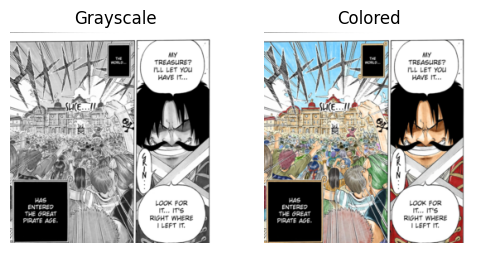

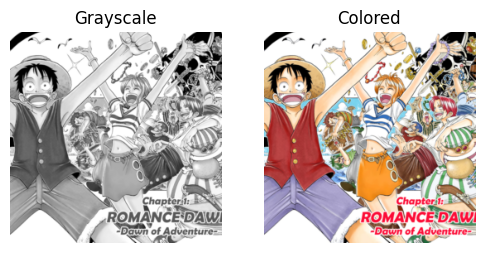

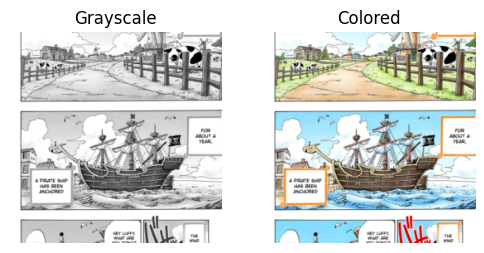

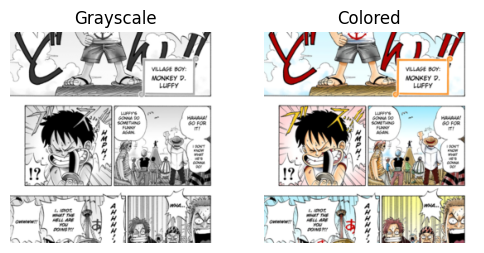

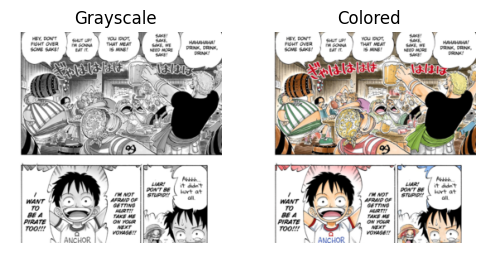

Batch shapes: torch.Size([8, 1, 256, 256]) torch.Size([8, 3, 256, 256])


In [8]:
# colorize_manga.py
"""
Standalone script to load the MichaelP84/manga-colorization-dataset
from Hugging Face and inspect sample pairs of grayscale (bw) and colored
images, and set up a PyTorch DataLoader for training a colorization model.
"""
%pip install -q datasets matplotlib torchvision torch
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


class MangaColorizationDataset(Dataset):
    """
    PyTorch dataset wrapping the Hugging Face manga-colorization dataset.
    Returns pairs (bw_tensor, color_tensor).
    """
    def __init__(self, split: str = "train", image_size: int = 256):
        # Load the dataset from Hugging Face
        self.dataset = load_dataset(
            "MichaelP84/manga-colorization-dataset", split=split
        )
        # Define transforms: resize + to tensor + normalize to [0,1]
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # item["bw_image"] and item["color_image"] are already PIL Image objects
        bw_image_obj = item["bw_image"]
        color_image_obj = item["color_image"]
        
        bw = bw_image_obj.convert("L")   # Grayscale
        color = color_image_obj.convert("RGB")

        bw_tensor = self.transform(bw)          # Shape: [1, H, W]
        color_tensor = self.transform(color)    # Shape: [3, H, W]
        return bw_tensor, color_tensor


def show_samples(dataset: MangaColorizationDataset, num_samples: int = 5):
    """
    Display a few sample pairs from the dataset.
    """
    for i in range(num_samples):
        bw, color = dataset[i]
        # Convert tensors to numpy arrays for display
        bw_img = bw.squeeze(0).numpy()
        color_img = color.permute(1, 2, 0).numpy()

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(bw_img, cmap='gray')
        plt.title('Grayscale')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(color_img)
        plt.title('Colored')
        plt.axis('off')

        plt.show()


if __name__ == "__main__":
    # Instantiate dataset
    dataset = MangaColorizationDataset(split="train", image_size=256)
    print(f"Dataset size: {len(dataset)} samples")

    # Show sample pairs
    show_samples(dataset, num_samples=5)

    # Example: wrap in DataLoader for training
    loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
    
    # Iterate one batch
    bw_batch, color_batch = next(iter(loader))
    print("Batch shapes:", bw_batch.shape, color_batch.shape)

    # Your colorization model training loop can follow here


In [9]:
# after some training_step()
ckpt_path = "manga_colorizer_epoch10.pth"
torch.save(model.state_dict(), ckpt_path)
print(f"Model saved to {ckpt_path}")


NameError: name 'model' is not defined

In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# 1) Install & Imports
# ══════════════════════════════════════════════════════════════════════════════
### colorize_manga.py this colorzes the images in the dataset
# (1) If you’re on Kaggle, just ensure pytorch_lightning and torchvision exist:
%pip install --quiet pytorch-lightning==1.9.0 torchvision==0.14.0

import os
import gc
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.color import lab2rgb
import pytorch_lightning as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models.inception import inception_v3
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pl.seed_everything(42)


# ══════════════════════════════════════════════════════════════════════════════
# 2) Dataset Definition (loads L and ab from top‐level .npy files)
# ══════════════════════════════════════════════════════════════════════════════

class ImageColorizationDataset(Dataset):
    """
    Expects exactly two numpy files at:
      /kaggle/input/image-colorization/gray_scale.npy   → shape (N, 224, 224)
      /kaggle/input/image-colorization/ab.npy           → shape (N, 224, 224, 2)
    We will take the first `n_samples` entries from each.  Return (L, ab) as Tensors.
    - L (1×224×224) floats in [0,1]
    - ab (2×224×224) floats in [0,1]
    """
    def __init__(self, root_dir, n_samples=5000):
        super().__init__()
        # Load the two .npy arrays (there’s no subfolder, just top-level)
        gray_path = os.path.join(root_dir, "gray_scale.npy")
        ab_path   = os.path.join(root_dir, "ab.npy")

        ab_full = np.load(ab_path)[:n_samples]      # shape → (5000, 224, 224, 2)
        L_full  = np.load(gray_path)[:n_samples]    # shape → (5000, 224, 224)

        # Normalize to [0,1]
        self.ab = ab_full.astype(np.float32) / 255.0
        self.L  = L_full.astype(np.float32) / 255.0

        # We'll convert to torch.Tensor per‐item
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return self.L.shape[0]

    def __getitem__(self, idx):
        # L: (224,224) → reshape to (224,224,1) to feed ToTensor() → (1,224,224)
        L_img = self.L[idx].reshape(224,224,1)
        L_t   = self.to_tensor(L_img)       # FloatTensor shape (1,224,224)

        # ab: already shape (224,224,2) → ToTensor() → (2,224,224)
        ab_img = self.ab[idx]
        ab_t   = self.to_tensor(ab_img)     # FloatTensor shape (2,224,224)

        return L_t, ab_t


# Create a train/val split
ROOT = "/kaggle/input/image-colorization"
dataset = ImageColorizationDataset(ROOT, n_samples=5000)
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# ══════════════════════════════════════════════════════════════════════════════
# 3) Utility: LAB → RGB converter (for plotting)
# ══════════════════════════════════════════════════════════════════════════════

def lab_to_rgb_batch(L, ab):
    """
    Convert a batch of (Lchannel, abchannels) → RGB for visualization.
      - L:   FloatTensor (B,1,224,224) in [0,1], interpret as L* = L×100
      - ab:  FloatTensor (B,2,224,224) in [0,1], interpret as a,b in [−128,128] via (ab−0.5)×256
    Returns np.array of shape (B,224,224,3) in [0,1].
    """
    L_np  = (L.detach().cpu().numpy() * 100.0).transpose(0, 2, 3, 1)         # → (B,224,224,1)
    ab_np = ((ab.detach().cpu().numpy() - 0.5) * 256.0).transpose(0, 2, 3, 1) # → (B,224,224,2)
    Lab   = np.concatenate([L_np, ab_np], axis=3)                            # → (B,224,224,3)

    rgb_list = []
    for img_lab in Lab:
        rgb = lab2rgb(img_lab.astype(np.float64))  # skimage returns float in [0,1]
        rgb_list.append(rgb)
    return np.stack(rgb_list, axis=0)  # (B,224,224,3)


# ══════════════════════════════════════════════════════════════════════════════
# 4) Model Definitions
#    A) ResU-Net Generator
#    B) PatchGAN Critic (WGAN-GP with R1)
# ══════════════════════════════════════════════════════════════════════════════

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        # If in_ch != out_ch or stride≠1, we need a 1×1 conv to match dimensions
        self.identity = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.body(x)
        skip = self.identity(x)
        return self.relu(out + skip)


class DownSampleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2),
            ResBlock(in_ch, out_ch)
        )

    def forward(self, x):
        return self.model(x)


class UpSampleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.resblock = ResBlock(in_ch + out_ch, out_ch)

    def forward(self, x, skip):
        x = self.upsample(x)
        x = torch.cat([x, skip], dim=1)
        return self.resblock(x)


class ResUNetGenerator(nn.Module):
    def __init__(self, in_ch=1, out_ch=2, dropout_rate=0.2):
        super().__init__()
        # Encoder
        self.enc1 = ResBlock(in_ch, 64)
        self.enc2 = DownSampleConv(64, 128)
        self.enc3 = DownSampleConv(128, 256)
        self.bridge = DownSampleConv(256, 512)
        # Decoder
        self.dec3 = UpSampleConv(512, 256)
        self.dec2 = UpSampleConv(256, 128)
        self.dec1 = UpSampleConv(128, 64)
        # Output conv (to 2 channels)
        self.out_conv = nn.Conv2d(64, out_ch, kernel_size=1)
        self.dropout = nn.Dropout2d(dropout_rate)

    def forward(self, x):
        e1 = self.enc1(x);   self.dropout(e1)
        e2 = self.enc2(e1);  self.dropout(e2)
        e3 = self.enc3(e2);  self.dropout(e3)
        b  = self.bridge(e3);self.dropout(b)
        d3 = self.dec3(b, e3)
        d2 = self.dec2(d3, e2)
        d1 = self.dec1(d2, e1)
        return self.out_conv(d1)


class PatchCritic(nn.Module):
    """
    A PatchGAN-style critic (WGAN-GP + R1 penalty).  Input is (L,ab) concatenated → 3 channels.
    Produces a single scalar score.
    """
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_f, out_f, norm=True):
            layers = [nn.Conv2d(in_f, out_f, kernel_size=4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_f))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels,  64,  norm=False),  #  (3 → 64)
            block(64,  128),                       # 64 → 128
            block(128, 256),                       # 128 → 256
            block(256, 512),                       # 256 → 512
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, L, ab):
        x = torch.cat([L, ab], dim=1)  # (B,3,224,224)
        return self.model(x)           # (B,1)


# ══════════════════════════════════════════════════════════════════════════════
# 5) LightningModule: CWGAN (Wasserstein + GP + R1)
# ══════════════════════════════════════════════════════════════════════════════

class CWGAN(pl.LightningModule):
    def __init__(self,
                 in_ch=1,
                 out_ch=2,
                 lr=2e-4,
                 lambda_recon=100.0,
                 lambda_gp=10.0,
                 r1_gamma=10.0):
        super().__init__()
        self.save_hyperparameters()

        self.generator = ResUNetGenerator(in_ch, out_ch)
        self.critic    = PatchCritic(in_ch + out_ch)
        self.lr = lr
        self.lambda_recon = lambda_recon
        self.lambda_gp    = lambda_gp
        self.r1_gamma     = r1_gamma

        self.criterion_L1 = nn.L1Loss()

    def forward(self, x):
        return self.generator(x)

    def configure_optimizers(self):
        opt_C = optim.Adam(self.critic.parameters(),    lr=self.lr, betas=(0.5, 0.9))
        opt_G = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.5, 0.9))
        # Return two optimizers: first for critic, second for generator
        return [opt_C, opt_G], []

    def gradient_penalty(self, real_ab, fake_ab, L):
        B = real_ab.size(0)
        alpha = torch.rand(B, 1, 1, 1, device=self.device)
        interpolated = (alpha * real_ab + (1 - alpha) * fake_ab).requires_grad_(True)
        logits = self.critic(L, interpolated)
        grad_outputs = torch.ones_like(logits, device=self.device)
        grads = torch.autograd.grad(
            outputs=logits,
            inputs=interpolated,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True
        )[0]
        grads = grads.view(B, -1)
        gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
        return gp

    def critic_step(self, batch):
        L_real, ab_real = batch
        ab_fake = self.generator(L_real).detach()

        real_logits = self.critic(L_real, ab_real)
        fake_logits = self.critic(L_real, ab_fake)

        # WGAN loss: Critic wants real_logits ↑, fake_logits ↓ →  (fake - real)
        loss_C = fake_logits.mean() - real_logits.mean()

        # gradient penalty
        gp = self.gradient_penalty(ab_real, ab_fake, L_real)

        # R1 penalty on real data: ∇ D(L,ab_real)²
        real_ab_var = ab_real.requires_grad_(True)
        real_score = self.critic(L_real, real_ab_var)
        grad_real = torch.autograd.grad(
            outputs=real_score.sum(), inputs=real_ab_var, create_graph=True
        )[0]
        r1_term = grad_real.view(grad_real.size(0), -1).pow(2).sum(dim=1).mean()

        loss_C_total = loss_C + self.lambda_gp * gp + self.r1_gamma * r1_term
        self.log("critic/loss", loss_C_total, on_step=True, on_epoch=True, prog_bar=True)
        return loss_C_total

    def generator_step(self, batch):
        L_real, ab_real = batch
        ab_fake = self.generator(L_real)
        fake_logits = self.critic(L_real, ab_fake)

        # Generator wants critic(L, fake) to be large → − E[ D(L,fake) ]
        loss_G_adv = -fake_logits.mean()
        # plus L1 reconstruction
        loss_G_rec = self.criterion_L1(ab_fake, ab_real) * self.lambda_recon
        loss_G = loss_G_adv + loss_G_rec

        self.log("gen/adv_loss", loss_G_adv, on_step=True, on_epoch=True)
        self.log("gen/rec_loss", loss_G_rec, on_step=True, on_epoch=True)
        self.log("gen/total_loss", loss_G, on_step=True, on_epoch=True, prog_bar=True)
        return loss_G

    def training_step(self, batch, batch_idx, optimizer_idx):
        # optimizer_idx=0 → critic, =1 → generator
        if optimizer_idx == 0:
            return self.critic_step(batch)
        else:
            return self.generator_step(batch)

    def validation_step(self, batch, batch_idx):
        # Just log a reconstruction error on the val set
        L_real, ab_real = batch
        ab_fake = self.generator(L_real)
        val_rec = self.criterion_L1(ab_fake, ab_real)
        self.log("val/rec_loss", val_rec, on_epoch=True, prog_bar=True)

    def on_epoch_end(self):
        # once per epoch, log a small grid of (L, real_color, fake_color)
        if self.trainer.global_rank == 0 and not hasattr(self, "logged_images"):
            self.logged_images = True
            val_batch = next(iter(val_loader))
            L_val, ab_val = val_batch
            L_val, ab_val = L_val.to(self.device), ab_val.to(self.device)
            with torch.no_grad():
                ab_fake = self.generator(L_val)

            rgb_real = lab_to_rgb_batch(L_val, ab_val)
            rgb_fake = lab_to_rgb_batch(L_val, ab_fake)
            rgb_L    = lab_to_rgb_batch(L_val, torch.zeros_like(ab_val))  # just display L as gray

            # show first 4
            fig, axes = plt.subplots(4, 3, figsize=(9, 12))
            for i in range(4):
                axes[i, 0].imshow(rgb_L[i]);    axes[i, 0].set_title("L (Input)");    axes[i, 0].axis("off")
                axes[i, 1].imshow(rgb_real[i]); axes[i, 1].set_title("Real Color");  axes[i, 1].axis("off")
                axes[i, 2].imshow(rgb_fake[i]); axes[i, 2].set_title("Fake Color");  axes[i, 2].axis("off")
            plt.tight_layout()
            self.logger.experiment.add_figure(f"Colorization_{self.current_epoch}", fig, self.current_epoch)
            plt.close(fig)


# ══════════════════════════════════════════════════════════════════════════════
# 6) Training Loop
# ══════════════════════════════════════════════════════════════════════════════

model = CWGAN(
    in_ch=1,
    out_ch=2,
    lr=2e-4,
    lambda_recon=100.0,
    lambda_gp=10.0,
    r1_gamma=10.0
)

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1 if torch.cuda.is_available() else 0,
    precision=16,                # mixed‐precision if GPU is available
    gradient_clip_val=1.0,
    progress_bar_refresh_rate=20,
)

trainer.fit(model, train_loader, val_loader)

# Save final weights (generator & critic)
torch.save(model.generator.state_dict(), "generator_final.pt")
torch.save(model.critic.state_dict(),    "critic_final.pt")


# ══════════════════════════════════════════════════════════════════════════════
# 7) Inference Example & Visualization
# ══════════════════════════════════════════════════════════════════════════════

model.eval().to(device)
val_iter = iter(val_loader)
L_real, ab_real = next(val_iter)
L_real, ab_real = L_real.to(device), ab_real.to(device)

with torch.no_grad():
    ab_fake = model.generator(L_real)

rgb_L    = lab_to_rgb_batch(L_real, torch.zeros_like(ab_real))
rgb_real = lab_to_rgb_batch(L_real, ab_real)
rgb_fake = lab_to_rgb_batch(L_real, ab_fake)

n_show = min(6, rgb_L.shape[0])
fig, axes = plt.subplots(n_show, 3, figsize=(9, 3 * n_show))
for i in range(n_show):
    axes[i, 0].imshow(rgb_L[i]);    axes[i, 0].set_title("Input L");    axes[i, 0].axis("off")
    axes[i, 1].imshow(rgb_real[i]); axes[i, 1].set_title("Real Color"); axes[i, 1].axis("off")
    axes[i, 2].imshow(rgb_fake[i]); axes[i, 2].set_title("Fake Color"); axes[i, 2].axis("off")
plt.tight_layout()
plt.show()


# ══════════════════════════════════════════════════════════════════════════════
# 8) (Optional) Quick Inception Score on a small subset
# ══════════════════════════════════════════════════════════════════════════════

class ISCalculator:
    def __init__(self, device):
        self.device = device
        self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
        self.inception.eval()

    def get_softmax_preds(self, imgs):
        """
        imgs: FloatTensor (N,3,224,224) in [0,1] → scale to [-1,1] for Inception
        """
        with torch.no_grad():
            imgs_norm = (imgs * 2.0) - 1.0
            preds = self.inception(imgs_norm)
            return F.softmax(preds, dim=1)

    def calculate_is(self, imgs, splits=10):
        """
        imgs: FloatTensor (N,3,224,224)
        Splits the N images into `splits` chunks → computes mean & std of exp(KL)
        """
        N = imgs.size(0)
        preds = self.get_softmax_preds(imgs).cpu().numpy()  # (N,1000)
        split_scores = []
        split_size = N // splits
        for k in range(splits):
            part = preds[k * split_size : (k+1)*split_size, :]
            p_y = np.mean(part, axis=0, keepdims=True)
            kl = part * (np.log(part + 1e-6) - np.log(p_y + 1e-6))
            kl = np.sum(kl, axis=1)
            split_scores.append(np.exp(np.mean(kl)))
        return np.mean(split_scores), np.std(split_scores)


# Gather ~500 real & 500 fake RGB images from val set:
real_list, fake_list = [], []
count = 0
for batch in val_loader:
    Lb, ab_rb = batch
    Lb, ab_rb = Lb.to(device), ab_rb.to(device)
    with torch.no_grad():
        ab_fb = model.generator(Lb)
    rgb_rb = lab_to_rgb_batch(Lb, ab_rb)
    rgb_fb = lab_to_rgb_batch(Lb, ab_fb)
    for i in range(rgb_rb.shape[0]):
        real_list.append(torch.tensor(rgb_rb[i].transpose(2,0,1)).float())
        fake_list.append(torch.tensor(rgb_fb[i].transpose(2,0,1)).float())
        count += 1
        if count >= 500:
            break
    if count >= 500:
        break

real_imgs = torch.stack(real_list, dim=0).to(device)  # (500,3,224,224)
fake_imgs = torch.stack(fake_list, dim=0).to(device)  # (500,3,224,224)

is_calc = ISCalculator(device)
is_real_mean, is_real_std = is_calc.calculate_is(real_imgs, splits=5)
is_fake_mean, is_fake_std = is_calc.calculate_is(fake_imgs, splits=5)

print(f"Inception Score on 500 real imgs:  mean={is_real_mean:.4f}, std={is_real_std:.4f}")
print(f"Inception Score on 500 fake imgs:  mean={is_fake_mean:.4f}, std={is_fake_std:.4f}")


ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.0 (from versions: 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0, 0.22.0)
ERROR: No matching distribution found for torchvision==0.14.0


Seed set to 42


Note: you may need to restart the kernel to use updated packages.


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/image-colorization/ab.npy'

In [ ]:
# ──────────────── demo_lama.py ────────────────
# this is for re drawing the image after puttin the new image and mask
import os
import subprocess
import argparse

def run_command(cmd):
    print(f"▶︎ {cmd}")
    ret = subprocess.call(cmd, shell=True)
    if ret != 0:
        raise RuntimeError(f"Command failed (exit {ret}):\n  {cmd}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description="Minimal LaMa inpainting demo: "
                    "downloads a pretrained model, "
                    "prepares one image+mask pair, "
                    "and runs bin/predict.py."
    )
    parser.add_argument(
        "--image", type=str, required=True,
        help="Path to a single RGB image (e.g. input.png) to inpaint"
    )
    parser.add_argument(
        "--mask", type=str, required=True,
        help="Path to a single grayscale mask (white=hole) (e.g. input_mask.png)"
    )
    parser.add_argument(
        "--outdir", type=str, default="lama_output",
        help="Directory where inpainted result will be written"
    )
    parser.add_argument(
        "--model-dir", type=str, default="big_lama_model",
        help="Directory in which to download/unzip the pretrained model"
    )
    args = parser.parse_args()

    # 1) Clone the LaMa repo (if not already present)
    if not os.path.isdir("lama"):
        run_command("git clone https://github.com/advimman/lama.git")

    # 2) Download a “big-lama” pretrained checkpoint from HuggingFace
    #    (Places2 “Big LaMa” model ~ 500 MB). Unzip into args.model_dir.
    if not os.path.isdir(args.model_dir):
        os.makedirs(args.model_dir, exist_ok=True)
        # Change to the model directory to download
        run_command(f"curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip")
        run_command("unzip big-lama.zip -d big_lama_model")
        run_command("rm big-lama.zip")

    # 3) Create a temporary folder with our single image+mask pair.
    demo_folder = "demo_pair"
    if not os.path.isdir(demo_folder):
        os.makedirs(demo_folder)
    # Copy the user-specified image and mask into demo_folder.
    # Name them so that LaMa’s default suffix logic picks them up:
    #   ───>  <basename>.png    and  <basename>_mask.png
    import shutil
    base_name = "image1"
    img_dest  = os.path.join(demo_folder, f"{base_name}.png")
    msk_dest  = os.path.join(demo_folder, f"{base_name}_mask.png")
    shutil.copy(args.image, img_dest)
    shutil.copy(args.mask, msk_dest)

    # 4) Prepare output directory
    if not os.path.isdir(args.outdir):
        os.makedirs(args.outdir, exist_ok=True)

    # 5) Set environment variables so that Python sees “lama/” as a module:
    os.environ["TORCH_HOME"] = os.path.abspath(args.model_dir)
    os.environ["PYTHONPATH"] = os.path.abspath("lama")

    # 6) Call LaMa’s built-in prediction script on our folder:
    #    We need to tell predict.py:
    #      – model.path=…    → location of “big_lama_model/models/best.ckpt”
    #      – indir=…         → folder with image1.png & image1_mask.png
    #      – outdir=…        → where to write image1_inpainted.png
    #
    #    (If you want refinement, append “refine=True”.)
    #
    cmd = (
        "python3 lama/bin/predict.py "
        f"model.path={os.path.abspath(args.model_dir)}/models/best.ckpt "
        f"indir={os.path.abspath(demo_folder)} "
        f"outdir={os.path.abspath(args.outdir)}"
    )
    run_command(cmd)

    print("\n✅  Finished. Your inpainted image is here:")
    print(f"      {os.path.abspath(args.outdir)}/{base_name}.png")
    print("   └→ (LaMa will overwrite the original “.png”; examine outdir to see the new image.)")


usage: ipykernel_launcher.py [-h] --image IMAGE --mask MASK [--outdir OUTDIR]
                             [--model-dir MODEL_DIR]
ipykernel_launcher.py: error: the following arguments are required: --image, --mask


SystemExit: 2

/home/chanakya/chanakya/UNI/translation_tool/manga-env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# ─── website.py ──────────────────────────────────────────────────────────────
# this the current code for the manga translator website
#  this does the following:
# 1. Detects manga panels using YOLOv8/9
# 2. Performs OCR on detected panels
# 3. Translates the text using various translation engines
# 4. Redraws the translated text onto the original manga panels
# 5. Displays the translated manga pages in a web interface (Streamlit or Gradio)
# 6. Allows users to upload manga pages and see the results in real-time
# 7. Supports multiple translation engines (Argos Translate, Ollama, Google Translate, DeepL, Azure Translator)
# 8. Provides options for customizing the translation process (e.g., selecting source/target languages)#
# ──────────────────────────────────────────────────────────────────────────────
"""
website.py – Self‑contained dual‑front‑end (Streamlit / Gradio) manga‑page translator.

Installation (once):
    pip install streamlit gradio ultralytics manga-ocr pillow numpy opencv-python \
        argostranslate==1.8.0 transformers==4.* sentencepiece torch

Run Streamlit (default):
    streamlit run website.py

Run Gradio:
    WEB_UI=gradio python website.py
"""


from __future__ import annotations

import os
import io
import math
import json
import time
import shutil
import tempfile
from functools import lru_cache
from typing import Dict, List, Tuple, Optional, Any
import textwrap

import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont, ImageColor


import torch
from ultralytics import YOLO
import torchvision.ops as ops
from manga_ocr import MangaOcr

# UI libs (always import; both are installed via requirements)
import streamlit as st


from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    MarianTokenizer,
    MarianMTModel,
)
from pathlib import Path
from enum import Enum
import ollama
import base64

import argostranslate.package
import argostranslate.translate
# Add these imports at the top of your file:
try:
    from googletrans import Translator as GoogleTranslator
except (ImportError, AttributeError):
    GoogleTranslator = None
    # and later in your translate() function:
    # if engine=="Google" and GoogleTranslator is None: fall back to another engine
# ─── googletrans helper ────────────────────────────────────────────────────────
if GoogleTranslator is not None:
    _GT = GoogleTranslator()          # one reusable client
else:
    _GT = None                        # will trigger fallback later


import deepl
from azure.ai.translation.text import TextTranslationClient
from azure.core.credentials import AzureKeyCredential
import requests




# ---------------------------------- CONFIG ---------------------------------- #
YOLO_MODEL_PATH = "yolo_train_run/full_finetune_phase20/weights/best.pt"        # <––– PUT your YOLOv8/9 weights here
# Example file structure:
# yolo_train_run/
# ├── full_finetune_phase20/
# │   ├── weights/
# │   │   ├── best.pt
# For more details, refer to the YOLOv8/YOLOv9 documentation: https://docs.ultralytics.com/
CACHE_DIR = os.path.join(tempfile.gettempdir(), "manga_translator_cache")
os.makedirs(CACHE_DIR, exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_SIDE = 1600          # shrink page to <=1600 px on longest side

# Translation model IDs
MARIAN_PREFIX = "Helsinki-NLP/opus-mt"
NLLB_ID = "facebook/nllb-200-distilled-600M"
DEEPL_API_KEY        = os.getenv("DEEPL_API_KEY", "")
AZURE_TRANSLATOR_KEY = os.getenv("AZURE_TRANSLATOR_KEY", "")
AZURE_ENDPOINT       = os.getenv("AZURE_ENDPOINT", "")
# Define default font path for text rendering.
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"

# Define detection classes
# SFX = 0
# SIGN = 1
# TEXT = 2
# REMOVAL = 3
# DIALOGUE = 4
DIALOGUE = 0
SOUND_EFFECTS = 1
SIGNS = 2
TEXT = 3
REMOVAL = 4
# Class IDs
@st.cache_resource(ttl=86400)
def get_yolo_model(conf: float = .25, iou: float = .45):
    model = YOLO(YOLO_MODEL_PATH)   # 1. load
    model.fuse()                    # 2. fuse ‑ in‑place, ignore return
    if DEVICE == "cuda":
        model.to("cuda").half()     # 3. move / cast
    model.predict(conf=conf, iou=iou)   # 4. warm‑up
    return model

# ---------------------------------------------------------------------------- #
# ---------- 1. keep ONE get_yolo_model ------------------------------------
@st.cache_resource(ttl=86400, show_spinner=False)
def get_yolo_model(conf: float = .25, iou: float = .45):
    model = YOLO(YOLO_MODEL_PATH)   # 1️⃣ create model
    model.fuse()                    # 2️⃣ optimise layers in‑place
    if DEVICE == "cuda":
        model.to("cuda").half()     # 3️⃣ move & cast
    model.predict(conf=conf, iou=iou)   # 4️⃣ warm‑up
    return model                    # 5️⃣ return the real object


@st.cache_resource(show_spinner=False, ttl=None)
def get_ocr():
    ocr = MangaOcr()
    if DEVICE == "cuda":
        ocr.model.to("cuda", dtype=torch.float16)
    return ocr



@lru_cache(maxsize=4)
def _load_marian(src: str, tgt: str):
    model_name = f"{MARIAN_PREFIX}-{src}-{tgt}"
    tok = MarianTokenizer.from_pretrained(model_name)
    mdl = MarianMTModel.from_pretrained(model_name)
    return tok, mdl


@lru_cache(maxsize=2)
def _load_nllb():
    tok = AutoTokenizer.from_pretrained(NLLB_ID)
    mdl = AutoModelForSeq2SeqLM.from_pretrained(NLLB_ID)
    return tok, mdl


def _ensure_argos_pkg(src: str, tgt: str):
    """Download Argos model pair lazily into cache dir."""
    installed = {(p.from_code, p.to_code) for p in argostranslate.package.get_installed_packages()}
    if (src, tgt) in installed:
        return
    # tiny network call; if offline will except and fallback
    pkg_url = f"https://huggingface.co/argosopentech/argos-translate-{src}_{tgt}/resolve/main/{src}_{tgt}.argos"
    try:
        fn = os.path.join(CACHE_DIR, f"{src}_{tgt}.argos")
        if not os.path.exists(fn):
            r = requests.get(pkg_url, timeout=10)
            r.raise_for_status()
            with open(fn, "wb") as f:
                f.write(r.content)
        argostranslate.package.install_from_path(fn)
    except Exception:
        pass  # fallback later


# ---------------------------------------------------------------------------- #
#                              UTILITY HELPERS                                 #
# ---------------------------------------------------------------------------- #
def whitest_pixel(arr: np.ndarray) -> Tuple[int, int, int]:
    if arr.ndim != 3 or arr.shape[-1] != 3:
        raise ValueError("Input array must have three color channels (H x W x 3).")
    idx = np.argmax(arr.sum(axis=-1))
    h, w, _ = arr.shape
    y, x = divmod(idx, w)
    return tuple(map(int, arr[y, x]))


def median_color(arr: np.ndarray) -> Tuple[int, int, int]:
    med = np.median(arr.reshape(-1, 3), axis=0)
    return tuple(int(x) for x in med)


def overlay(
    pil_img: Image.Image,
    boxes,            # Iterable[(x1,y1,x2,y2), ...]
    texts,            # Iterable[str, …]  – already wrapped
    sizes,            # Iterable[int, …]  – font sizes per text
    colors            # Iterable[Tuple[int,int,int,int], …]  RGBA
) -> Image.Image:
    """
    Draws *texts* on a transparent layer and composites it on top of *pil_img*.

    Parameters
    ----------
    pil_img : PIL.Image
        Original manga page (RGB or RGBA).
    boxes : list[tuple[int,int,int,int]]
        Bounding boxes where each string should be rendered.
    texts : list[str]
        Text strings (one per box).
    sizes : list[int]
        Font size per string.
    colors : list[tuple[int,int,int,int]]
        RGBA text colours, e.g. (0,0,255,255).

    Returns
    -------
    PIL.Image
        The original page with the overlay composited (mode “RGB”).
    """
    base   = pil_img.convert("RGBA")
    layer  = Image.new("RGBA", base.size, (255, 255, 255, 0))
    draw   = ImageDraw.Draw(layer)

    for (x1, y1, x2, y2), txt, sz, col in zip(boxes, texts, sizes, colors):
        font = load_font(sz)
        wbox = draw.textbbox((0, 0), txt, font=font)
        tw, th = wbox[2] - wbox[0], wbox[3] - wbox[1]
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        draw.multiline_text(
            (cx, cy),
            txt,
            font=font,
            fill=col,
            anchor="mm",
            align="center",
        )

    # composite and drop alpha
    return Image.alpha_composite(base, layer).convert("RGB")


def load_font(size:int):
    try:
        return ImageFont.truetype(FONT_PATH, size)
    except OSError:
        return ImageFont.load_default()



def fit_and_wrap_text(
    draw: ImageDraw.Draw,
    text: str,
    box: Tuple[int, int, int, int],
    font_path: str = FONT_PATH,
    max_size: int = 60,
    min_size: int = 12,
    step: int = 2
) -> Tuple[str, ImageFont.FreeTypeFont]:
    """
    Returns a (wrapped_text, font) pair such that:
      • wrapped_text is broken into lines that never exceed box width
      • font is the largest size between max_size and min_size that
        makes the rendered block fit inside box (w × h)
    """
    x1, y1, x2, y2 = box
    box_w, box_h = x2 - x1, y2 - y1

    # Estimate avg char width by measuring “M” once per size
    for size in range(max_size, min_size - 1, -step):
        try:
            font = ImageFont.truetype(font_path, size=size)
        except OSError:
            continue  # skip sizes if ttf missing
        
        # Compute bounding box for a reference character "M"
        m_bbox = draw.textbbox((0, 0), "M", font=font)
        avg_char_w = max(5, m_bbox[2] - m_bbox[0])  # Ensure a minimum threshold for avg_char_w
        max_chars = max(1, box_w // avg_char_w)     # Avoid unexpected behavior
        # Optionally recompute avg_char_w and max_chars (if needed)
        avg_char_w = max(1, m_bbox[2] - m_bbox[0])
        max_chars = box_w // avg_char_w or 1
        
        # Wrap by words using textwrap
        wrapped = "\n".join(textwrap.wrap(text, width=max_chars,break_long_words=False, break_on_hyphens=False))
        
        # Measure the whole block
        tb = draw.multiline_textbbox((0, 0), wrapped, font=font)
        text_w, text_h = tb[2] - tb[0], tb[3] - tb[1]
        
        if text_w <= box_w and text_h <= box_h:
            return wrapped, font

    # Fallback: use the smallest size
    font = ImageFont.truetype(font_path, size=min_size)
    m_bbox = draw.textbbox((0, 0), "M", font=font)
    avg_char_w = max(1, m_bbox[2] - m_bbox[0])
    wrapped = "\n".join(textwrap.wrap(text, width=box_w // avg_char_w or 1))
    return wrapped, font

# ---------------------------------------------------------------------------- #
#                    GEMMA3 TRANSLATION INTEGRATION                            #
# ---------------------------------------------------------------------------- #
class ResponseFormat(Enum): JSON = 'json_object'; TEXT = 'text'

def call_model(
    prompt:str='', image_path:Path|None=None,
    response_format:ResponseFormat=ResponseFormat.TEXT,
    system_prompt:str=''
) -> str:
    msgs=[]
    if system_prompt: msgs.append({'role':'system','content':system_prompt})
    if image_path:
        b64 = base64.b64encode(Path(image_path).read_bytes()).decode()
        uri = f"data:image/png;base64,{b64}"
        msgs.append({'role':'user','content':f'![Image]({uri})\n\n{prompt}'})
    else:
        msgs.append({'role':'user','content':prompt})
    resp = ollama.chat(
        model='gemma3:4b', messages=msgs, keep_alive='1h',
        format='' if response_format==ResponseFormat.TEXT else 'json',
        options={'temperature':1.0,'min_p':0.01,'repeat_penalty':1.0,'top_k':64,'top_p':0.95}
    )
    reply = resp.message.content
    return reply


# ---------------------------------------------------------------------------- #
#                           TRANSLATION ABSTRACTION                            #
# ---------------------------------------------------------------------------- ##
def translate(text: str, src: str, tgt: str, engine: str) -> str:
    """
    Translate *text* from *src* → *tgt* using the chosen *engine*.
    If that engine fails, fall back to Argos → Google in that order.
    If Google also fails, return the original text unchanged.
    """
    text = text.strip()
    if not text:
        return ""

    try:
        if engine == "Gemma3":
            # 1) System prompt now mentions both src and tgt
            system_prompt = (
                f"You are a world-class translator with deep expertise in {src} and {tgt}. "
                f"Translate the following {src} text into fluent, idiomatic {tgt}, preserving nuance and tone. "
                "Output ONLY the translated text, with no commentary or formatting."
            )

            # 2) Wrap the text and label it clearly
            user_prompt = (
                f"=== Begin {src} text ===\n"
                f"{text}\n"
                f"=== End {src} text ==="
            )

            # 3) Call the model
            reply = call_model(
                prompt=user_prompt,
                response_format=ResponseFormat.TEXT,
                system_prompt=system_prompt
            )
            # 4) Debug log of what we got back
            print("<<< GEMMA3 OUTPUT:\n", reply)
            # 5) Return the actual reply
            return reply
        # ── Google Translate (unofficial) ────────────────────────────────
        if engine == "Google":
            #if _GT is None:                           # library missing
                # Check if Argos is installed before falling back
                #if not argostranslate.package.get_installed_packages():
                    #raise RuntimeError("Argos Translate is not installed. Please install it to use as a fallback.")
                #return translate(text, src, tgt, "Argos")

            
            return _GT.translate(text, src=src or "auto", dest=tgt).text
            
                #return translate(text, src, tgt, "Argos")

        # ── DeepL ────────────────────────────────────────────────────────
        elif engine == "DeepL":
            translator = deepl.Translator(DEEPL_API_KEY)
            resp = translator.translate_text(
                text, source_lang=src.upper(), target_lang=tgt.upper()
            )
            return resp.text

        # ── Azure Translator ─────────────────────────────────────────────
        elif engine == "Azure":
            cred   = AzureKeyCredential(AZURE_TRANSLATOR_KEY)
            client = TextTranslationClient(endpoint=AZURE_ENDPOINT, credential=cred)
            result = client.translate(content=[text], from_parameter=src, to=[tgt])
            return result[0].translations[0].text

        # ── Argos (offline) ──────────────────────────────────────────────
        elif engine == "Argos":
            _ensure_argos_pkg(src, tgt)
            return argostranslate.translate.translate(text, src, tgt)

        # ── MarianMT (Helsinki) ──────────────────────────────────────────
        elif engine == "MarianMT":
            tok, mdl = _load_marian(src, tgt)
            out = mdl.generate(**tok(text, return_tensors="pt"), max_length=256)
            return tok.decode(out[0], skip_special_tokens=True)

        # ── NLLB (Meta) ──────────────────────────────────────────────────
        elif engine == "NLLB":
            tok, mdl = _load_nllb()
            if src not in tok.lang_code_to_id:
                raise ValueError(f"Unsupported src lang {src!r} for NLLB")
            inp = tok(text, return_tensors="pt")
            inp["forced_bos_token_id"] = tok.lang_code_to_id.get(tgt, 0)
            out = mdl.generate(**inp, max_length=256)
            return tok.decode(out[0], skip_special_tokens=True)

        # ── Unknown engine name ──────────────────────────────────────────
        else:
            raise ValueError(f"Unknown translation engine: {engine!r}")

    # ── If the chosen engine blew up, fall back hierarchically ──────────
    except Exception:
        if engine not in ("Google", "Argos"):
            return translate(text, src, tgt, "Argos")
        if engine != "Google":
            return translate(text, src, tgt, "Google")
        return text  # All fallbacks failed


# ---------------------------------------------------------------------------- #
#                          PROCESSING                                          #
# ---------------------------------------------------------------------------- #
#def group_boxes_by_class(result, conf_thresh=.25, iou_thresh=.45):
    groups = {int(k): [] for k in range(len(result.names))}

    # collect boxes
    for box, cls, conf in zip(result.boxes.xyxy.cpu(),
                              result.boxes.cls.int().cpu(),
                              result.boxes.conf.cpu()):
        if conf < conf_thresh:
            continue
        groups[int(cls)].append((tuple(map(float, box)), float(conf)))

    if iou_thresh:
        for cls, items in groups.items():
            if not items:
                continue
            # → float32 on the SAME device as torchvision
            device = "cuda" if DEVICE == "cuda" else "cpu"
            b = torch.tensor([bb for bb, _ in items],
                             dtype=torch.float32, device=device)
            s = torch.tensor([ss for _, ss in items],
                             dtype=torch.float32, device=device)

            keep = ops.nms(b, s, iou_thresh).tolist()
            groups[cls] = [items[i] for i in keep]

    return groups

def group_boxes_by_class(result,
                          conf_thresh: float = 0.25,
                          iou_thresh: float = 0.45) -> Dict[int, List[Tuple]]:
    """Return {class_id: [(x1,y1,x2,y2), score]} with **native ints**."""
    groups = {int(i): [] for i in range(len(result.names))}

    # ➊ filter boxes
    for box, cls, conf in zip(result.boxes.xyxy.cpu(),
                              result.boxes.cls.cpu(),
                              result.boxes.conf.cpu()):
        if conf < conf_thresh:
            continue
        # -> turn each coordinate into a python int via .item()
        bbox = tuple(int(v.item()) for v in box)
        groups[int(cls.item())].append((bbox, float(conf.item())))

    # ➋ optional per‑class NMS
    if iou_thresh:
        for cid, items in groups.items():
            if not items:
                continue
            b = torch.tensor([bb for bb, _ in items], dtype=torch.float32)
            s = torch.tensor([sc for _, sc in items])
            keep = ops.nms(b, s, iou_thresh)
            groups[cid] = [items[i] for i in keep]

    return groups
# ---------------------------------------------------------------------------- #



def find_containing_dialogue(
    rem_box: Tuple[int, int, int, int],
    dialogues: List[Tuple[Tuple[int, int, int, int], float]]
) -> Optional[Tuple[int, int, int, int]]:
    """
    Given a removal‐region box and a list of dialogue bubbles (each as (box, confidence)),
    return the first dialogue‐box that fully contains rem_box, or None if there is none.
    """
    rx1, ry1, rx2, ry2 = rem_box
    for (dx1, dy1, dx2, dy2), _ in dialogues:
        if rx1 >= dx1 and ry1 >= dy1 and rx2 <= dx2 and ry2 <= dy2:
            return (dx1, dy1, dx2, dy2)
    return None

# ---------------------------------------------------------------------------- #
#                          PROCESSING                                          #
# ---------------------------------------------------------------------------- #
def process_page(
    pil_img: Image.Image,
    src_lang: str,
    tgt_lang: str,
    engine: str,
    conf: float,
    iou_thr: float,
    text_color: str = "#0000FF",
) -> Tuple[Image.Image, List[Dict[str, Any]]]:
    """
    Args
    ----
    pil_img : PIL.Image
        Original manga page.
    src_lang / tgt_lang : ISO 639‑1 codes (“ja”, “en”, …).
    engine : Which translation back‑end to use.
    conf / iou_thr : YOLO score & NMS thresholds.
    text_color : Hex colour for overlay text.

    Returns
    -------
    out_img : PIL.Image
        Page with cleaned bubbles + translated text.
    logs : list[dict]
        Per‑region metadata (class, source text, translation, …).
    """
    # ── overlay buffers (collect first, render once at the end) ──────────
    ov_boxes:  list[tuple[int, int, int, int]] = []
    ov_texts:  list[str]                       = []
    ov_sizes:  list[int]                       = []
    ov_colors: list[tuple[int, int, int, int]] = []

    # ── prep  ────────────────────────────────────────────────────────────
    model   = get_yolo_model(conf, iou_thr)
    ocr     = get_ocr()
    np_img  = np.array(pil_img.convert("RGB"))
    out_img = pil_img.copy()
    draw    = ImageDraw.Draw(out_img)
    logs: list[Dict[str, Any]] = []
    text_rgb = ImageColor.getrgb(text_color)

    # ── detect & group  ──────────────────────────────────────────────────
    det    = model.predict(source=np_img, conf=conf, iou=iou_thr, verbose=False)[0]
    groups = group_boxes_by_class(det, conf_thresh=conf, iou_thresh=iou_thr)

    # ── per‑region processing  ───────────────────────────────────────────
    for cls in (SOUND_EFFECTS, SIGNS, TEXT, REMOVAL):
        name = {SOUND_EFFECTS: "SFX", SIGNS: "SIGN", TEXT: "TEXT", REMOVAL: "REMOVAL"}[cls]

        for (x1, y1, x2, y2), _ in groups[cls]:
            if x2 - x1 < 20 or y2 - y1 < 20:       # skip tiny boxes
                continue

            # ① crop for OCR (optionally use parent dialogue bubble)
            if cls == REMOVAL and DIALOGUE in groups:
                parent = find_containing_dialogue((x1, y1, x2, y2), groups[DIALOGUE])
                crop_box = parent if parent else (x1, y1, x2, y2)
            else:
                crop_box = (x1, y1, x2, y2)
            sub_img = pil_img.crop(crop_box)

            # ② OCR
            try:
                src_text = ocr(sub_img) or ""
            except Exception:
                src_text = ""

            # ③ translate
            tgt_text = translate(src_text, src_lang, tgt_lang, engine) if src_text else ""

            # ④ log
            logs.append(
                {
                    "class": name,
                    "src_lang": src_lang,
                    "src_text": src_text,
                    "tgt_lang": tgt_lang,
                    "tgt_text": tgt_text,
                }
            )

            # ⑤ blank background (white for REMOVAL, median colour otherwise)
            patch = np_img[y1:y2, x1:x2]
            fill  = whitest_pixel(patch) if cls == REMOVAL else None
            draw.rectangle([x1, y1, x2, y2], fill=fill)

            # ⑥ collect overlay info (render later)
            if tgt_text:
                wrapped, font = fit_and_wrap_text(draw, tgt_text, (x1, y1, x2, y2))
                ov_boxes.append((x1, y1, x2, y2))
                ov_texts.append(wrapped)
                ov_sizes.append(font.size)
                ov_colors.append((*text_rgb, 255))

    # ── single overlay render ────────────────────────────────────────────
    if ov_boxes:
        out_img = overlay(out_img, ov_boxes, ov_texts, ov_sizes, ov_colors)

    return out_img, logs



# ---------------------------------------------------------------------------- #
#                             STREAMLIT FRONT‑END                              #
# ---------------------------------------------------------------------------- #


def build_streamlit() -> None:
    st.set_page_config("Manga Translator")
    st.title("📖 Manga Translator (Offline · Open Source)")

    # ── sidebar inputs ───────────────────────────────────────────────────────
    with st.sidebar:
        src_lang   = st.text_input("Source language code",  value="ja")
        tgt_lang   = st.text_input("Target language code",  value="en")
        engine     = st.selectbox(
            "Translation engine",
            ["Gemma3","MarianMT", "Google", "DeepL", "Azure", "Argos", "NLLB"],
        )
        conf       = st.slider("YOLO confidence", 0.1, 1.0, 0.25, 0.05)
        iou_thr    = st.slider("NMS IoU threshold", 0.1, 1.0, 0.45, 0.05)
        text_color = st.color_picker("Overlay text color", "#0000FF")

    # ── file input ───────────────────────────────────────────────────────────
    img_file = st.file_uploader("Upload manga page",
                                type=["png", "jpg", "jpeg"])

    # ‼️ everything that touches the file stays **inside** this guard
    if img_file:
        # 1️⃣ preview original
        st.image(img_file, caption="Original Page",
                 use_container_width=True)

        # 2️⃣ run the translation pipeline
        pil_img = Image.open(img_file).convert("RGB")
        with st.spinner("Detecting & Translating …"):
            out_img, logs = process_page(
                pil_img,
                src_lang=src_lang,
                tgt_lang=tgt_lang,
                engine=engine,
                conf=conf,
                iou_thr=iou_thr,
                text_color=text_color,
            )

        # 3️⃣ show translated page
        st.image(out_img, caption="Translated",
                 use_container_width=True)

        # 4️⃣ show per‑bubble logs
        for log in logs:
            with st.expander(f"{log['class']}  "
                             f"({log['src_lang']} → {log['tgt_lang']})"):
                st.write("Src:", log["src_text"] or "—")
                st.write("Tgt:", log["tgt_text"] or "—")

    st.caption("All processing is local · models are cached for speed.")


# ---------------------------------------------------------------------------- #
#                               GRADIO FRONT‑END                               #
# ---------------------------------------------------------------------------- #
def build_gradio() -> None:
    import gradio as gr
    def gr_process(img, src_lang, tgt_lang, engine, conf, iou, text_color):
        if img is None:
            return None, "No image"
        pil_img = Image.fromarray(img).convert("RGB")
        out_img, logs = process_page(
            pil_img,
            src_lang=src_lang,
            tgt_lang=tgt_lang,
            engine=engine,
            conf=conf,
            iou_thr=iou,
            text_color=text_color,
        )
        return np.array(out_img), json.dumps(logs, ensure_ascii=False, indent=2)

    with gr.Blocks(title="Manga Translator") as demo:
        gr.Markdown("# 📖 Manga Translator (Offline · Open Source)")
        with gr.Row():
            img_in  = gr.Image(type="numpy", label="Input page")
            img_out = gr.Image(type="numpy", label="Translated")
        with gr.Row():
            src_lang   = gr.Textbox(value="ja", label="Source lang code")
            tgt_lang   = gr.Textbox(value="en", label="Target lang code")
            engine     = gr.Dropdown(
                ["Gemma3","Google", "DeepL", "Azure", "Argos", "MarianMT", "NLLB"],
                value="Gemma3",
                label="Engine"
            )
            conf       = gr.Slider(0.1, 1.0, 0.25, label="YOLO confidence")
            iou        = gr.Slider(0.1, 1.0, 0.45, label="NMS IoU threshold")
            text_color = gr.ColorPicker(value="#0000FF", label="Overlay text color")
        logs_box = gr.Textbox(label="Logs (JSON)")

        gr.Button("Translate").click(
            gr_process,
            inputs=[img_in, src_lang, tgt_lang, engine, conf, iou, text_color],
            outputs=[img_out, logs_box],
        )

    demo.launch(share=False)


# ---------------------------------------------------------------------------- #
#                                      MAIN                                    #
# ---------------------------------------------------------------------------- #
if __name__ == "__main__":
    ui = os.getenv("WEB_UI", "streamlit")
    ui = ui.lower() if isinstance(ui, str) else "streamlit"
    if ui == "gradio":
        build_gradio()
    else:
        build_streamlit()

2025-06-02 22:13:47.954 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 22:13:47.955 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 22:13:48.022 
  command:

    streamlit run /home/chanakya/chanakya/UNI/translation_tool/manga-env/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-02 22:13:48.022 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 22:13:48.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 22:13:48.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-02 22:13:48.023 Thread 'MainThread': missing ScriptRunConte

combine all of the to get the write thing and that works too